In [1]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.6/303.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_

In [2]:
# Log in to your W&B account
import wandb

# Use wandb-core, temporary for wandb's new backend
wandb.require("core")

In [3]:
!wandb login

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
wandb.init(
    project="AIIA_AFAC",

    config={
    "learning_rate": 0.0001,
    "batch_size": 32,
    "architecture": "CNN-WRN(additional train)",
    "dataset": "Custum Car Dataset",
    "epochs": 10,
    "depth" : 22,
    "width_factor" : 10,
    "num_classes" : 10,
    "drop_rate" : 0.3,
    "criterion" : "CrossEntropyLoss",
    }
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hangmin3320 (hangmin3320-aiia). Use `wandb login --relogin` to force relogin


In [1]:
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
from torch import optim
from PIL import Image, ImageOps
import torch
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BATCH_SIZE = 32
EPOCH = 10
LR = 0.0001
depth = 22
width_factor = 10
num_classes = 10
drop_rate = 0.3
criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
new_model_train = False
model_type = "CNN_WideResNet"
dataset = "originCustumCardata"
save_model_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_{dataset}.pt"
save_history_path = f"/content/drive/MyDrive/Colab Notebooks/results/{model_type}_history_{dataset}.pt"

print(device)

cpu


In [4]:
def rgba_to_rgb(image):
    return image.convert('RGB')

In [5]:
transform_train = transforms.Compose([
    transforms.Lambda(lambda img: rgba_to_rgb(img)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Lambda(lambda img: rgba_to_rgb(img)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [6]:
train_dir = '/content/drive/MyDrive/AIIA/AFAC/dataset/originDataset/train'
valid_dir = '/content/drive/MyDrive/AIIA/AFAC/dataset/originDataset/valid'
test_dir = '/content/drive/MyDrive/AIIA/AFAC/dataset/originDataset/test'

train_DS = datasets.ImageFolder(train_dir, transform=transform_train)
valid_DS = datasets.ImageFolder(valid_dir, transform=transform_test)
test_DS = datasets.ImageFolder(test_dir, transform=transform_test)

train_DL = DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
valid_DL = DataLoader(valid_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
class WideBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, drop_rate=0.0):
        super(WideBasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=drop_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class WideResNet(nn.Module):
    def __init__(self, depth, width_factor, num_classes, drop_rate=0.0):
        super(WideResNet, self).__init__()

        assert (depth - 4) % 6 == 0, "Depth must be 6n + 4"
        n = (depth - 4) // 6

        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)

        # Stages of the network
        self.stage1 = self._make_layer(WideBasicBlock, 16 * width_factor, n, stride=2, drop_rate=drop_rate)
        self.stage2 = self._make_layer(WideBasicBlock, 32 * width_factor, n, stride=2, drop_rate=drop_rate)
        self.stage3 = self._make_layer(WideBasicBlock, 64 * width_factor, n, stride=2, drop_rate=drop_rate)

        self.bn1 = nn.BatchNorm2d(64 * width_factor)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(64 * width_factor, num_classes)

        # Weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, out_channels, num_blocks, stride, drop_rate):
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_channels, out_channels, stride if i == 0 else 1, drop_rate))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        # 'last_conv_output = x' 이건 GradCam 쓸 때만 주석해제
        #last_conv_output = x
        x = self.relu(self.bn1(x))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x #, last_conv_output
        # last_conv_output return도

    def get_last_conv_layer(self):
        return self.stage3[-1].conv2

In [8]:
def WRN(depth, width_factor, num_classes, drop_rate=0.0):
    return WideResNet(depth, width_factor, num_classes, drop_rate)

In [9]:
model = WRN(depth, width_factor, num_classes, drop_rate).to(device)

In [10]:
x = torch.randn(1,1,256,256).to(device)
type(model(x))

torch.Tensor

In [11]:
def Train(model, train_DL, val_DL, criterion, optimizer,
          EPOCH, BATCH_SIZE, save_model_path, save_history_path, **kwargs):

    if "LR_STEP" in kwargs:
        scheduler = StepLR(optimizer, step_size = kwargs["LR_STEP"], gamma = kwargs["LR_GAMMA"])
    else:
        scheduler = None

    loss_history = {"train" : [], "val":[]}
    acc_history = {"train" : [], "val":[]}
    best_loss = 9999
    for ep in range(EPOCH):
        epoch_start = time.time()
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch : {ep+1}, current_LR = {current_lr}")

        model.train() # train mode로 전환
        train_loss, train_acc, _ = loss_epoch(model, train_DL, criterion, optimizer)
        loss_history["train"] += [train_loss]
        acc_history["train"] += [train_acc]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss, val_acc, _ = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            acc_history["val"] += [val_acc]

            if val_loss < best_loss: # early stopping
                best_loss = val_loss
                # optimizer도 같이 save하면 여기서부터 재학습 시작 가능
                torch.save({"model" : model,
                            "ep" : ep,
                            "optimizer" : optimizer,
                            "scheduler" : scheduler}, save_model_path)
        if "LR_STEP" in kwargs:
            scheduler.step()
        # print loss
        print(f"train loss: {round(train_loss,5)}, "
              f"val loss: {round(val_loss,5)} \n"
              f"train acc: {round(train_acc,1)} %, "
              f"val acc: {round(val_acc,1)} %, time: {round(time.time()-epoch_start)} s")

        wandb.log({"train_loss" : train_loss,
                   "val_loss" : val_loss,
                   "train_acc" : train_acc,
                   "val_acc" : val_acc})

        print("-"*20)

    torch.save({"loss_history" : loss_history,
                "acc_history" : acc_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

    return loss_history

In [12]:
def loss_epoch(model, DL, criterion, optimizer = None):
    N = len(DL.dataset) # the number of data
    rloss = 0; rcorrect = 0
    for x_batch, y_batch in tqdm(DL, leave=False):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # inference
        y_hat = model(x_batch)
        # loss
        loss = criterion(y_hat, y_batch)
        # update
        if optimizer is not None:
            optimizer.zero_grad() # gradient 누적을 막기 위한 초기화
            loss.backward() # backpropagation
            optimizer.step() # weight update
        # loss accumulation
        loss_b = loss.item() * x_batch.shape[0] # batch loss # BATCH_SIZE를 곱하변 마지막 18개도 32개를 곱하니까...
        rloss += loss_b # running loss
        # accuracy accumulation
        pred = torch.argmax(y_hat, dim=1)
        corrects_b = torch.sum(pred == y_batch).item()
        rcorrect += corrects_b
    loss_e = rloss/N
    accruracy_e = rcorrect/N * 100

    return loss_e, accruracy_e, rcorrect

In [13]:
def Test(model, test_DL, criterion):
    model.eval()
    with torch.no_grad():
        test_loss, test_acc, rcorrect = loss_epoch(model, test_DL, criterion)
    print()
    print(f"Test loss : {round(test_loss,5)}")
    print(f"Test accuracy : {rcorrect}/{len(test_DL.dataset)} ({round(test_acc,1)} %)")
    return round(test_acc,1)

In [14]:
def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(device)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu")

    plt.figure(figsize=(10,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class == true_class else "r")

In [15]:
def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

In [16]:
torch.cuda.empty_cache()

Epoch : 1, current_LR = 0.0001


  2%|▏         | 1/59 [00:14<14:10, 14.66s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train loss: 0.31286, val loss: 0.78029 
train acc: 94.1 %, val acc: 74.9 %, time: 819 s
--------------------
Epoch : 2, current_LR = 0.0001


train loss: 0.23158, val loss: 0.86492 
train acc: 96.7 %, val acc: 74.5 %, time: 140 s
--------------------
Epoch : 3, current_LR = 0.0001


train loss: 0.20331, val loss: 1.67778 
train acc: 97.0 %, val acc: 58.0 %, time: 144 s
--------------------
Epoch : 4, current_LR = 0.0001


train loss: 0.19129, val loss: 0.82912 
train acc: 97.0 %, val acc: 72.8 %, time: 145 s
--------------------
Epoch : 5, current_LR = 0.0001


train loss: 0.1648, val loss: 0.71948 
train acc: 97.5 %, val acc: 76.1 %, time: 147 s
--------------------
Epoch : 6, current_LR = 0.0001


train loss: 0.13511, val loss: 1.17007 
train acc: 98.6 %, val acc: 65.0 %, time: 147 s
--------------------
Epoch : 7, current_LR = 0.0001


train loss: 0.11916, val loss: 1.02046 
train acc: 98.7 %, val acc: 69.1 %, time: 146 s
--------------------
Epoch : 8, current_LR = 0.0001


train loss: 0.10586, val loss: 1.96671 
train acc: 98.7 %, val acc: 56.0 %, time: 147 s
--------------------
Epoch : 9, current_LR = 0.0001


train loss: 0.11219, val loss: 2.25256 
train acc: 98.5 %, val acc: 49.8 %, time: 146 s
--------------------
Epoch : 10, current_LR = 0.0001


train loss: 0.11053, val loss: 1.31298 
train acc: 98.4 %, val acc: 64.2 %, time: 147 s
--------------------


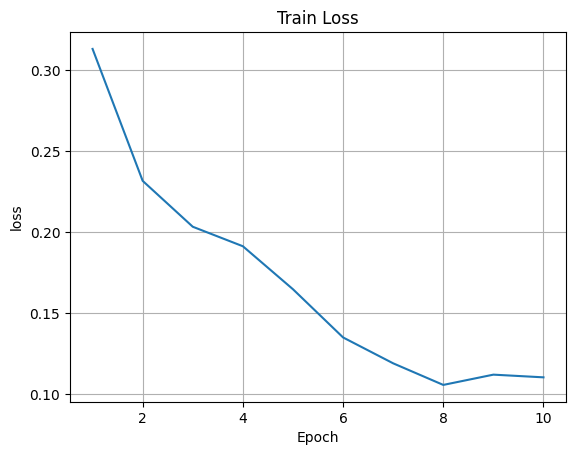

In [22]:
if new_model_train:
    optimizer = optim.Adam(model.parameters(), lr = LR)
    # optimizer = optim.SGD(model.parameters(), lr = LR, momentum=0.9)
    loss_history = Train(model, train_DL, valid_DL, criterion, optimizer, EPOCH,
                         BATCH_SIZE, save_model_path, save_history_path)
    loss_history = list(loss_history.values())[0]
    plt.plot(range(1, EPOCH+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("Train Loss")
    plt.grid()
else:
    optimizer = optim.Adam(load_model.parameters(), lr = LR)
    # optimizer = optim.SGD(model.parameters(), lr = LR, momentum=0.9)
    loss_history = Train(load_model, train_DL, valid_DL, criterion, optimizer, EPOCH,
                        BATCH_SIZE, save_model_path, save_history_path)
    loss_history = list(loss_history.values())[0]
    plt.plot(range(1, EPOCH+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.title("Train Loss")
    plt.grid()

In [17]:
load_model = torch.load(save_model_path)["model"]

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
model.eval()
Test(load_model, test_DL, criterion)


Test loss : 0.87098
Test accuracy : 169/232 (72.8 %)


72.8

In [ ]:
load_model.eval()

WideResNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (stage1): Sequential(
    (0): WideBasicBlock(
      (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.3, inplace=False)
      (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): WideBasicBlock(
      (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affin

In [ ]:
count_params(load_model)

26801114

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


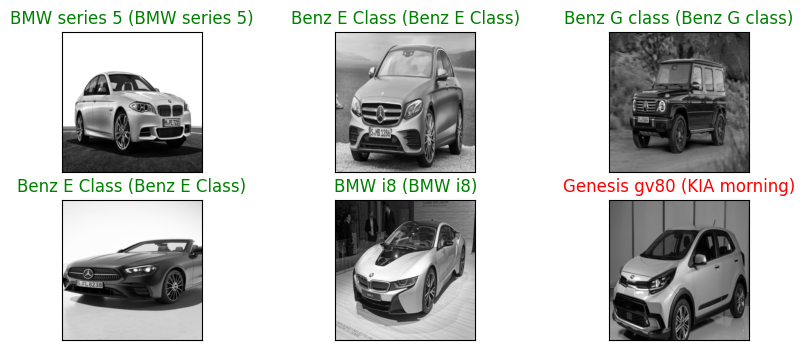

In [ ]:
Test_plot(load_model, test_DL)

# GradCam

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        # Register hooks to capture feature maps and gradients
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.feature_maps = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        # Forward pass
        model_output, _ = self.model(input_tensor)  # Unpack outputs

        # Ensure model_output is a tensor (e.g., logits)
        if isinstance(model_output, tuple):
            model_output = model_output[0]

        # Zero gradients
        self.model.zero_grad()

        # Backward pass with target class
        model_output[:, target_class].backward(retain_graph=True)

        # Compute weights using global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute Grad-CAM
        cam = torch.relu(torch.sum(weights * self.feature_maps, dim=1))

        # Normalize the CAM map to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

torch.Size([1, 1, 256, 256])


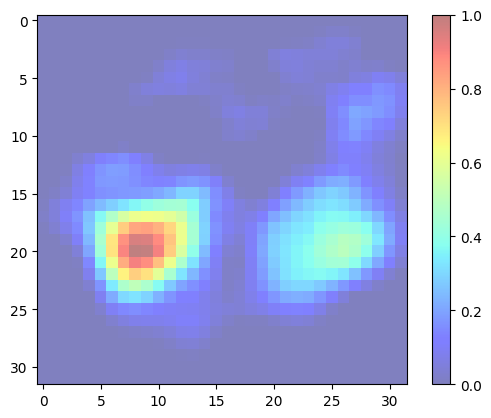

In [ ]:
model = torch.load(save_model_path)["model"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()  # Set model to evaluation mode

grad_cam = GradCAM(model, model.get_last_conv_layer())

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure the input size matches the model's expected input
    transforms.ToTensor(),
])

image_path = '/content/drive/MyDrive/AIIA/AFAC/dataset/originDataset/test/BMW i8/BMW i8_104.jpg'
image = Image.open(image_path).convert('L')  # Convert to grayscale if needed
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# input_tensor = torch.randn(1, 1, 256, 256).to(device)
print(input_tensor.shape)

# Target class for visualization
target_class = 0  # Example class index

# Generate Grad-CAM
cam = grad_cam.generate_cam(input_tensor, target_class)

# Convert the CAM tensor to a NumPy array for visualization
cam_np = cam.cpu().numpy().squeeze()

# Plot the Grad-CAM heatmap
plt.imshow(cam_np, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

# GradCam-overlay

In [ ]:
import os
import random

def get_random_image_path(base_dir='test'):
    """
    Get a random image path from the specified base directory.

    Parameters:
    - base_dir: The base directory to search for images.

    Returns:
    - A randomly selected image path.
    """
    image_paths = []

    # Traverse the base directory and collect image paths with '.jpg' extension
    for root, dirs, files in os.walk('/content/drive/MyDrive/AIIA/AFAC/dataset/originDataset/test'):
        for file in files:
            if file.lower().endswith('.jpg'):  # Check for .jpg extension
                image_paths.append(os.path.join(root, file))

    # Check if any images were found
    if not image_paths:
        raise ValueError("No images found in the specified directory.")

    # Randomly select an image path
    return random.choice(image_paths)

# Get a random image path from the test directory
image_path = get_random_image_path('test')
print(f"Randomly selected image path: {image_path}")


Randomly selected image path: /content/drive/MyDrive/AIIA/AFAC/dataset/originDataset/test/Genesis gv80/Genesis gv80_254.jpg


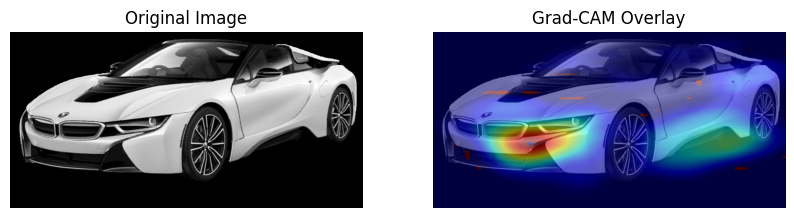

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.feature_maps = None
        self.gradients = None

        # Register hooks to capture feature maps and gradients
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.feature_maps = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        # Register hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class):
        # Forward pass
        model_output, _ = self.model(input_tensor)  # Unpack outputs

        # Ensure model_output is a tensor (e.g., logits)
        if isinstance(model_output, tuple):
            model_output = model_output[0]

        # Zero gradients
        self.model.zero_grad()

        # Backward pass with target class
        model_output[:, target_class].backward(retain_graph=True)

        # Compute weights using global average pooling of gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Compute Grad-CAM
        cam = torch.relu(torch.sum(weights * self.feature_maps, dim=1))

        # Normalize the CAM map to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

def overlay_gradcam(cam, original_image, alpha=0.5):
    # Resize CAM to match the original image size
    cam = cam.cpu().numpy().squeeze()
    cam_resized = np.array(Image.fromarray(cam).resize(original_image.size, Image.BICUBIC))

    # Normalize CAM to range [0, 255]
    cam_resized = np.uint8(255 * cam_resized)

    # Convert the original image to RGB if it's grayscale
    if original_image.mode != 'RGB':
        original_image = original_image.convert('RGB')

    # Convert CAM to a heatmap using the 'jet' colormap
    heatmap = plt.get_cmap('jet')(cam_resized / 255.0)[:, :, :3]  # Ignore alpha channel

    # Convert heatmap to PIL Image
    heatmap_image = Image.fromarray(np.uint8(255 * heatmap))

    # Overlay the heatmap on the original image
    overlayed_image = Image.blend(original_image, heatmap_image, alpha)
    return overlayed_image

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the trained model
model = torch.load(save_model_path)["model"]

model.to(device)
model.eval()  # Set model to evaluation mode

# Initialize GradCAM with the last conv layer
grad_cam = GradCAM(model, model.get_last_conv_layer())

# Prepare your input tensor (e.g., a single image with batch dimension)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ensure the input size matches the model's expected input
    transforms.ToTensor()
])

# Load an example image
image_path = get_random_image_path('test')
image = Image.open(image_path).convert('L')  # Convert to grayscale if needed
original_image = ImageOps.grayscale(image)

# Transform image to tensor
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Target class for visualization (e.g., class index 0)
target_class = 0  # Change this to the desired class index

# Generate Grad-CAM
cam = grad_cam.generate_cam(input_tensor, target_class)

# Overlay Grad-CAM on the original image
overlayed_image = overlay_gradcam(cam, original_image, alpha=0.5)

# Display the original and overlayed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Overlay")
plt.imshow(overlayed_image)
plt.axis('off')

plt.show()

# Confusion matrix

 12%|█▎        | 1/8 [00:20<02:23, 20.49s/it]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 8/8 [02:13<00:00, 16.72s/it]


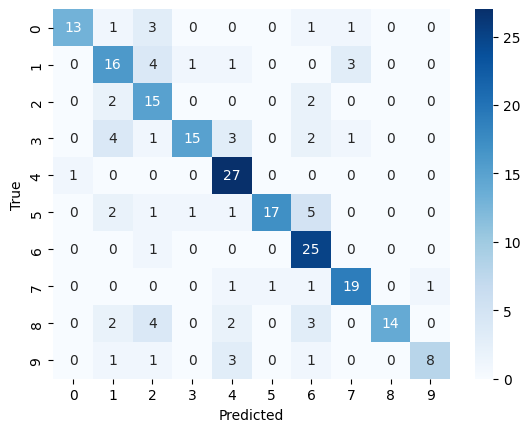

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

load_model.eval()
with torch.no_grad():
  y_true = []
  y_pred = []
  for x_batch, y_batch in tqdm(test_DL, leave = True):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_hat = load_model(x_batch)
    pred = y_hat.argmax(dim=1)

    y_hat = y_batch.to('cpu')
    pred = pred.to('cpu')

    y_hat = y_hat.tolist()
    pred = pred.tolist()

    y_true = y_true + y_hat
    y_pred = y_pred + pred

cm = confusion_matrix(y_true, y_pred)

print("\n")
sns.heatmap(cm, annot = True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

# Path to the image file
image_path = '/content/drive/MyDrive/AIIA/AFAC/dataset/train/KIA K5/KIA K5_143.jpg'

# Check if the image file exists
if not os.path.exists(image_path):
    print(f"Error: The file '{image_path}' does not exist.")
else:
    # Open the image
    try:
        image = Image.open(image_path)
        print("Image successfully opened.")
    except Exception as e:
        print(f"Error opening image: {e}")

    # Convert the image to grayscale
    try:
        grayscale_image = image.convert('L')
        print("Image successfully converted to grayscale.")
    except Exception as e:
        print(f"Error converting image to grayscale: {e}")

    # Save the grayscale image (optional, can be skipped if not needed)
    try:
        grayscale_image_path = 'KIA_K5_143_grayscale.jpg'
        grayscale_image.save(grayscale_image_path)
        print(f"Grayscale image saved as '{grayscale_image_path}'.")
    except Exception as e:
        print(f"Error saving grayscale image: {e}")

    # Plot the grayscale image
    try:
        plt.figure(figsize=(8, 8))  # Set the figure size
        plt.imshow(grayscale_image, cmap='gray')  # Display the image in grayscale
        plt.axis('off')  # Hide the axis
        plt.title('Grayscale Image')
        plt.show()
        print("Grayscale image plotted.")
    except Exception as e:
        print(f"Error plotting grayscale image: {e}")
